# Проект: 2 вариант, задание 1

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import pingouin as pg
from statsmodels.stats import proportion as prop

sns.set(rc={'figure.figsize':(12,8)})

Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа):

In [2]:
groups = pd.read_csv('2_groups.csv', sep=';')
groups.shape

(74484, 2)

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.duplicated().any()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


False

Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [5]:
group_add = pd.read_csv('2_group_add.csv')
group_add.shape

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


(92, 2)

In [6]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [7]:
group_add.duplicated().any()

False

Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

In [8]:
active_studs = pd.read_csv('2_active_studs.csv')
active_studs.shape

(8341, 1)

In [9]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [10]:
active_studs.duplicated().any()

False

Файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [11]:
checks = pd.read_csv('2_checks.csv', sep=';')
checks.shape

(541, 2)

In [12]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [13]:
checks.duplicated().any()

False

Проведем <b>разведочный анализ данных

Посмотрим подробнеее на активных и заплативших пользователей. Проверим есть ли те, что заплатили, но при этом не были активными

In [14]:
st_ids = active_studs.student_id.values
bugged_users = checks.query('student_id not in @st_ids')
bugged_users.head()

,student_id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0


In [15]:
bugged_users.shape

(149, 2)

Имеем 149 багованных записей в наших данных - это те пользователи, которые были неактивны, но при этом как-то совершили оплату (возможно это был автоплатеж). Так как мы не знаем, откуда эти записи, лучше от них избавиться.

In [16]:
# Заведем переменную, где будут лежать только активные пользователи, совершившие оплату
active_payed_studs = checks.merge(active_studs, how='inner', on='student_id')
active_payed_studs.head()

,student_id,rev
0,1627,990.0000
1,100300,990.0000
2,108270,290.0000
3,264473,1900.0001
4,274352,690.0000


In [17]:
active_payed_studs.shape

(392, 2)

Теперь посмотрим на разбивку по группам.

In [18]:
# Добавим файл с новыми данными
groups_full = groups.append(group_add)
groups_full.shape

(74576, 2)

In [19]:
# Есть ли дупликаты в обоих файлах
groups_full.duplicated().any()

False

In [20]:
groups_full['grp'].value_counts()

B    59883
A    14693
Name: grp, dtype: int64

Посмотрим сколько вообще активных пользователей для каждой группы. Как видно наблюдений в тестовой выборке, ощутимо больше, чем контрольной. Поэтому посчитаем активных пользователей в относительной шкале.

In [21]:
# Определим активных студентов, посмотрим их по группам
active_df = groups_full.merge(active_studs, how='left', left_on='id', right_on='student_id')
active_df.shape

(74576, 3)

In [22]:
active_df['active'] = (~active_df['student_id'].isna()).apply(lambda x: int(x))

In [23]:
active_df.head()

,id,grp,student_id,active
0,1489,B,NaN,0
1,1627,A,1627.0,1
2,1768,B,NaN,0
3,1783,B,NaN,0
4,1794,A,NaN,0


In [24]:
active_df_ad = (active_df.groupby(['grp'])['active']
 .value_counts(normalize=True).round(2)
 .to_frame('perc').reset_index()
)

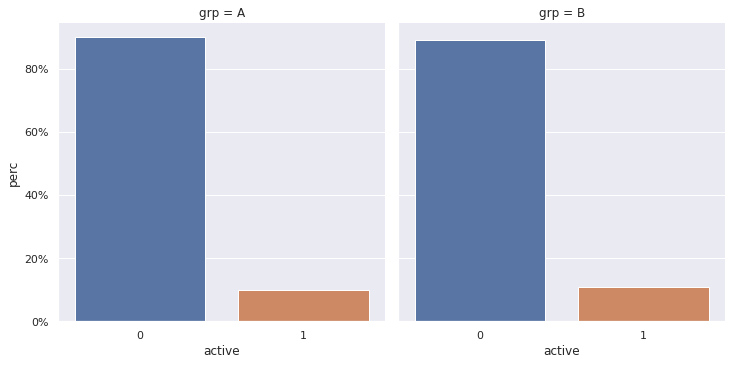

In [25]:
# sns.countplot(active_df, x='active', hue='grp', stat="percent");
from  matplotlib.ticker import PercentFormatter
p = sns.catplot(x='active', y='perc', col='grp', kind='bar', data=active_df_ad)
for ax in p.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

Как видно, в относительной шкале активности в обеих группах слабо отличаются

Теперь рассмотрим заплативших пользователей в процентном соотношении.

In [26]:
# Определим плативших студентов, посмотрим их по группам
payed_df = groups_full.merge(active_payed_studs, how='left', left_on='id', right_on='student_id')
payed_df.shape

(74576, 4)

In [27]:
payed_df['payed'] = (~payed_df['student_id'].isna()).apply(lambda x: int(x))

In [28]:
payed_df.head()

,id,grp,student_id,rev,payed
0,1489,B,NaN,NaN,0
1,1627,A,1627.0,990.0,1
2,1768,B,NaN,NaN,0
3,1783,B,NaN,NaN,0
4,1794,A,NaN,NaN,0


In [29]:
payed_df_ad = (payed_df.groupby(['grp'])['payed']
 .value_counts(normalize=True).round(2)
 .to_frame('perc').reset_index()
)

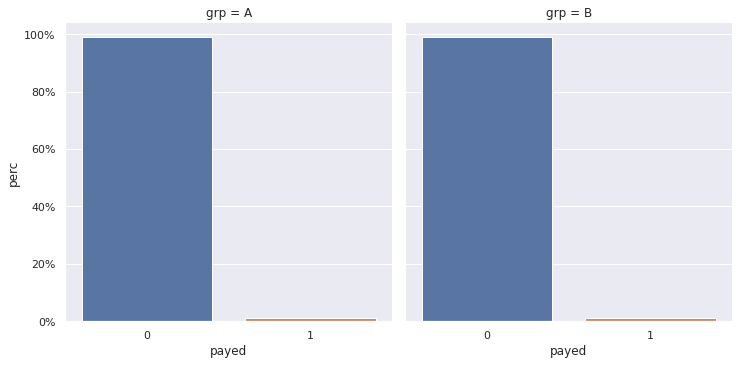

In [30]:
# sns.countplot(active_df, x='active', hue='grp', stat="percent");
from  matplotlib.ticker import PercentFormatter
p = sns.catplot(x='payed', y='perc', col='grp', kind='bar', data=payed_df_ad)
for ax in p.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

Для оплативших пользователей ситуация такая же, как и с активностью пользователей - для теста и контроля они мало различимы

Взглянем на боксплот выручки для каждой из групп.

In [31]:
# Определим группы платящих пользователей
payed_users = groups_full.merge(active_payed_studs, how='right', left_on='id', right_on='student_id')
payed_users.shape

(392, 4)

In [32]:
payed_users.head()

,id,grp,student_id,rev
0,1627,A,1627,990.0000
1,100300,B,100300,990.0000
2,108270,B,108270,290.0000
3,264473,B,264473,1900.0001
4,274352,B,274352,690.0000


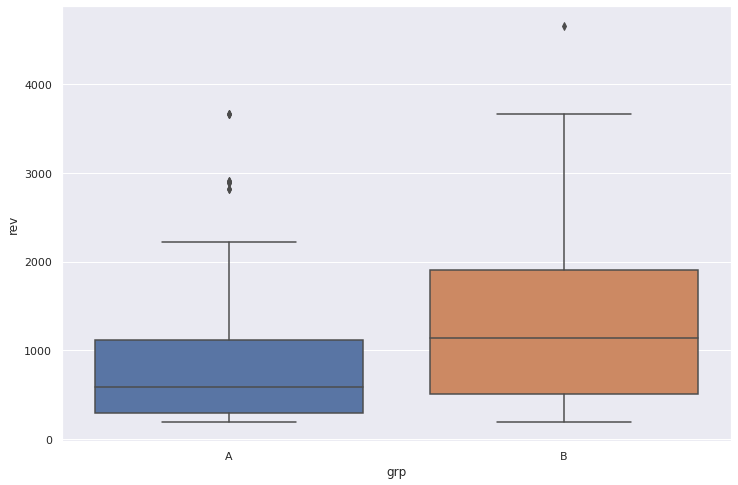

In [33]:
sns.boxplot(data=payed_users, x='grp', y='rev');

Как можно заметить разброс для тестовой группы намного больше, чем у теста. Однако аномальных значений там меньше.

Посмотрим, как распределеная выручка для обеих групп.

In [34]:
payed_with_groups_df = groups_full.merge(active_payed_studs, how='right', left_on='id', right_on='student_id')
payed_with_groups_df.shape

(392, 4)

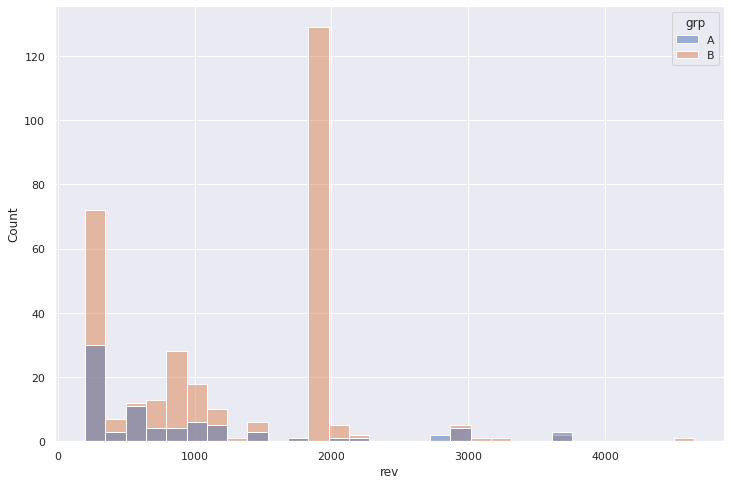

In [35]:
sns.histplot(data=payed_with_groups_df, x='rev', hue='grp', bins=30);

Оплат стало ощутимо больше на тесте, нежели в контроле.

## Определимся с метриками

<b>Целевая</b> метрика - CR из активных пользователей в оплату 

Будем считать:

$H_0$: CR в обоих группах примерно равен

$H_1$: CR отличаются

Возьмем уровень значимости 0.05

<b>Guardrail</b> метрика - ARPU

Будем считать:

$H_0$: ARPU не изменился ($ARPU_B = ARPU_A$)

$H_1$: ARPU изменился ($ARPU_B \neq ARPU_A$)

(Проверяем именно такую альтернативу, потому что retention в данном эксперименте - метрика, которую нельзя ронять)

Возьмем уровень значимости 0.05

### Guardrail метрика

In [36]:
# Добавим группы к юзерам, принимавших участие в эксперименте
all_users = active_studs.merge(groups_full, how='left', left_on='student_id', right_on='id')
all_users.shape

(8341, 3)

In [37]:
# Добавим информацию о платежах юзеров
all_users = all_users.merge(checks, how='left', on='student_id')
all_users.shape

(8341, 4)

In [38]:
all_users.head()

,student_id,id,grp,rev
0,581585,581585,A,NaN
1,5723133,5723133,A,NaN
2,3276743,3276743,B,NaN
3,4238589,4238589,A,NaN
4,4475369,4475369,B,NaN


In [39]:
# Чтобы посчитать средний чек заменим все значения None на ноль
all_users['rev'] = all_users['rev'].fillna(0)

In [40]:
# И посчитаем ARPU
all_users.groupby('grp').agg({'rev': 'mean'})

,rev
grp,
A,47.347204
B,58.058798


Проверим гомогенность дисперсий в двух группах

In [41]:
pg.homoscedasticity(data=payed_users, dv='rev', group='grp')

,W,pval,equal_var
levene,3.075682,0.080257,True


Дисперсии в двух группах гомогенны, исходя из теста выше

Теперь проверим нормальное распределение средних (нужно для t-test)

In [60]:
sample_means_control = []
sample_means_target = []

for i in range(5000):
    sample_control = all_users.loc[all_users['grp']=='A', 'rev'].sample(frac=1, replace=True)
    sample_target = all_users.loc[all_users.grp=='B', 'rev'].sample(frac=1, replace=True)
    sample_means_control.append(sample_control.mean())
    sample_means_target.append(sample_target.mean())

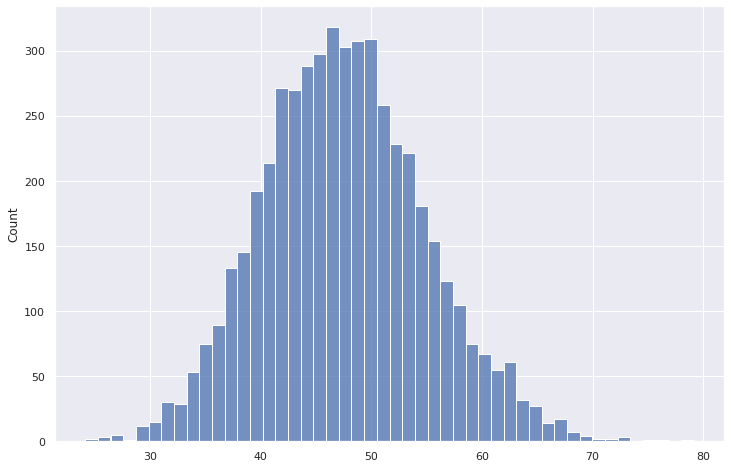

In [61]:
sns.histplot(data=sample_means_control);

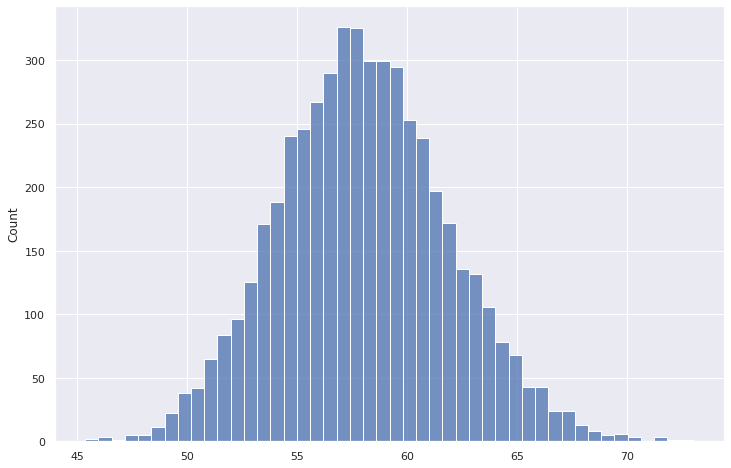

In [62]:
sns.histplot(data=sample_means_target);

Проверим, являются ли полученные распледеления нормальными

In [63]:
# Пирсон
stats.normaltest(sample_means_control), stats.normaltest(sample_means_target)

(NormaltestResult(statistic=42.74716242494661, pvalue=5.218811622581646e-10),
 NormaltestResult(statistic=19.698519600013572, pvalue=5.27862509409807e-05))

In [64]:
# Шапиро-Уилк
print(pg.normality(sample_means_control), pg.normality(sample_means_target), sep='\n')

          W          pval  normal
0  0.996984  1.776684e-08   False
          W      pval  normal
0  0.998524  0.000138   False


Как видно, проведя тесты на нормальность, просимулированные распределения средних не являются нормальными. Поэтому целесообразно использовать Bootstrap.

In [47]:
control_df = all_users.query("grp=='A'")["rev"]
exp_df = all_users.query("grp=='B'")["rev"]
mean_diff = []

for i in range(10000):
    sample_data_control = control_df.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.mean()
    
    sample_data_exp = exp_df.sample(frac=1, replace=True)
    sample_mean_exp = sample_data_exp.mean()
    
    sample_mean_diff = sample_mean_control - sample_mean_exp
    mean_diff.append(sample_mean_diff)

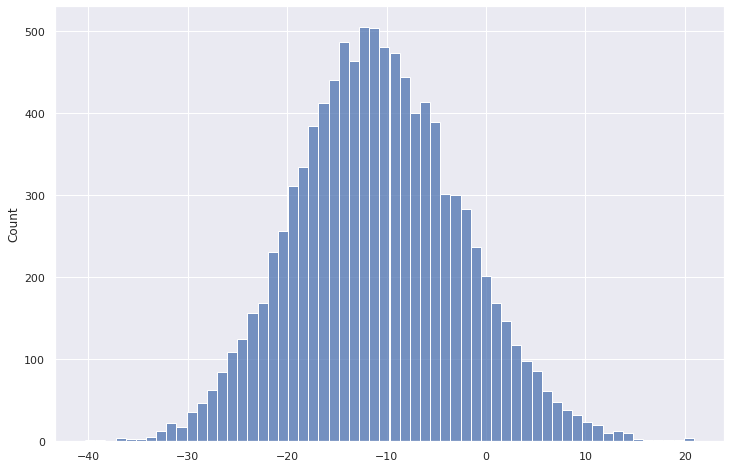

In [48]:
# Посмотрим на распределение разницы средних
sns.histplot(data=mean_diff);

In [49]:
# Посмотрим на доверительные интервалы
pd.Series(mean_diff).quantile(0.025), pd.Series(mean_diff).quantile(0.975)

(-26.55779143546066, 5.875752262418346)

In [50]:
# Рассчитаем разницу между контрольной и тестовой группой
all_users.query('grp=="A"').rev.mean() - all_users.query('grp=="B"').rev.mean()
# all_users.groupby('grp').agg({'rev': 'mean'})

-10.711593942529369

Видно, что полученная разность входит в 95% доверительный интервал, следовательно мы не можем отклонить Н0, что хорошо: мы не можем сказать, что ARPU изменился.

### Целевая метрика

In [51]:
# Воспользуемся фрэймом all_users
# Определим пользователей, которые дошли до целевого действия
all_users['CR'] = (all_users['rev'] != 0).apply(lambda x: int(x))

In [52]:
all_users.head()

,student_id,id,grp,rev,CR
0,581585,581585,A,0.0,0
1,5723133,5723133,A,0.0,0
2,3276743,3276743,B,0.0,0
3,4238589,4238589,A,0.0,0
4,4475369,4475369,B,0.0,0


In [53]:
all_users.shape

(8341, 5)

Удостоверимся, что нет активного юзера, который совершил покупку несколько раз

In [54]:
all_users.groupby('id').agg({'CR': 'sum'}).value_counts()

CR
0     7949
1      392
dtype: int64

In [55]:
# Посчитаем CR в оплату вручную
all_users.groupby('grp').agg({'CR': 'mean'})

,CR
grp,
A,0.050715
B,0.046156


In [56]:
# Посмотрим на таблицу сопряжённости
pd.crosstab(all_users.CR, all_users.grp)

grp,A,B
CR,,
0,1460,6489
1,78,314


Рассмотрим  <b>критерий Хи-квадрат</b>

In [59]:
exp, obs, stat = pg.chi2_independence(data=all_users, x='grp', y='CR')
stat

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


Как видно из приведенного выше теста, мы не можем сказать, что CR в оплату статистически значимо отличается в тестовой группе. 

Из результатов теста можно сказать, что хоть наша Guardrail метрика не упала, но целевая метрика значимо не изменилась. Поэтому не стоит торопиться с введением новой фичи.

Для начала стоит разобраться с багованными записями (юзерами, которые были неактивны, но произвели оплату). Затем как вариант можно проверить систему сплитования и дизайн эксперимента в целом.